# TF-IDF + persistence homology

## TF-IDF

In [1]:
import numpy as np
from scipy.sparse import csr_matrix, linalg, csgraph
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import tools

## TODO

- Un bon preprocessing
- Exploiter des propriétés sur les barcodes

### Notes on the implementation

- On n'utilise pas ```for``` dès possible
- On utilise sparse matrices
- Données dupliquées

In [2]:
def my_split(docs : list[str]) -> list[list[str]]:
  return [[w.lower() for w in re.sub(r'[^\w]', ' ', s).split() if w.isalpha() and len(w) >= 3] for s in docs]

# O(nm log(nm))
def tfidf(docs : list[list[str]]) -> tuple[list[str], np.ndarray, list[np.ndarray]]:
    words = []
    for doc in docs:
        words.extend(doc)
    words = np.unique(words)
    lk = dict(zip(words, range(len(words))))
    tf = np.zeros((len(docs), len(words)), dtype=np.float64)
    for i, doc in enumerate(docs):
        indices, counts = np.unique([lk[term] for term in doc], return_index=True)
        tf[i, indices] = counts/len(doc)

    df = np.zeros((len(words),), dtype=np.float64)
    for doc in docs:
        df[np.unique([lk[term] for term in doc])] += 1
    idf = np.log(len(docs) / df)

    tfidf = tf * idf
    return words, idf, tfidf

In [3]:
pairs = tools.categories_description_pairs("details.json")[:2000]
def dedup():
  s = set()
  res = []
  for p in pairs:
    if p[1] not in s:
      res.append(p)
      s.add(p[1])
  return res
pairs = dedup()
print(len(pairs))
print(pairs[0:3])

1682
[(['Enchères', 'Aventures dans la jungle', 'Collection / famille', 'Exploration', "Placement d'ouvrier"], '\n                      Vous êtes à la tête d’un groupe d’aventuriers et d’archéologues en expédition dans les ruines du temple de Quetzal. Les joueurs ont 5 tours pour explorer l’île de Quetzal et collecter de précieux artefacts. Les joueurs lancent leurs meeples et les envoient dans les différents lieux de l’île pour récupérer des artefacts. Ils les livrent ensuite pour améliorer leurs fouilles ou marquer des points de victoire et tenter de gagner la partie.\n                  '), (['Card-driven', 'Combinaison', 'Coopération', 'Deck building', 'Locomotion & voyage', 'Humour', 'Gestion', 'Science fiction'], '\n                      Le Dr Foo a créé une terrrrible Machine à voyager dans le temps ! Aidé par les Clones de lui-même qu’il génère dans le temps, il vise à concrétiser Omniscience 2000, son projet de se rendre maître de l’Univers. Mais les failles spatio-temporelles 

In [4]:
categories = list(set(((sum([p[0] for p in pairs],[])))))
print(len(categories), categories)

180 ['Trahison', 'Stop ou encore', 'Capture', 'Connaissances', 'Jeux de cartes', 'Taquin', 'Jeu de carte à collectionner', 'Simulation', 'Elimination', 'Autres', 'Enchères à poing fermé', 'Course', 'Chant & Danse', 'Afrique', 'Fantastique', 'Rapidité', 'Chiffres', 'Bande dessinée', 'Hasard (Dé, Cartes, ...)', 'Affrontement', 'Médiéval', 'Pari', 'Déplacement', 'Vampire', 'Flore', 'Placement', 'Aviation', 'Enchères', 'Tuile', 'Immobilier', 'Semi-coopération', 'Rangement', 'Musique & Chanson', 'Aventures dans la jungle', 'Bourse & finances', 'Conquête', 'Espion', 'Déduction', 'Cartes à jouer', 'Collection / famille', 'Lettres & chiffres', 'Objectif secret', 'Jeu de logique', 'Diplomatie', 'Samurai', 'Prise de risque', 'Locomotion & voyage', 'Renaissance', 'TV & Cinéma', 'Desert', 'Asie', 'Programmation', 'Levées', 'Chat', 'Rôle secret', 'Les îles', 'Enchères cachées', 'Chifoumi', 'Gestion', 'Équilibre', 'Rails', 'Casse-tête', 'Cirque', 'Contes, Mythes & Légendes', 'Plateau modulaire', 'Pu

In [5]:
docs = [p[1] for p in pairs]
docs = my_split(docs)
for x in docs[:10]:
    print(x)

['vous', 'êtes', 'tête', 'groupe', 'aventuriers', 'archéologues', 'expédition', 'dans', 'les', 'ruines', 'temple', 'quetzal', 'les', 'joueurs', 'ont', 'tours', 'pour', 'explorer', 'île', 'quetzal', 'collecter', 'précieux', 'artefacts', 'les', 'joueurs', 'lancent', 'leurs', 'meeples', 'les', 'envoient', 'dans', 'les', 'différents', 'lieux', 'île', 'pour', 'récupérer', 'des', 'artefacts', 'ils', 'les', 'livrent', 'ensuite', 'pour', 'améliorer', 'leurs', 'fouilles', 'marquer', 'des', 'points', 'victoire', 'tenter', 'gagner', 'partie']
['foo', 'créé', 'une', 'terrrrible', 'machine', 'voyager', 'dans', 'temps', 'aidé', 'par', 'les', 'clones', 'lui', 'même', 'génère', 'dans', 'temps', 'vise', 'concrétiser', 'omniscience', 'son', 'projet', 'rendre', 'maître', 'univers', 'mais', 'les', 'failles', 'spatio', 'temporelles', 'sème', 'sur', 'son', 'passage', 'auront', 'sûrement', 'raison', 'espace', 'quantique', 'bien', 'avant', 'cela', 'rejoignez', 'agence', 'dans', 'peau', 'ses', 'agents', 'les',

In [6]:
words, idf, vecs = tfidf(docs)
vecs = csr_matrix(vecs)

In [7]:
print("Number of words", len(words))
print(words)

Number of words 24721
['aaaaahhhh' 'abaddon' 'abaisse' ... 'œuvré' 'ลอยกระทง' 'エセ芸術家ニューヨークへ行く']


- Il y a trop de mots, parce que je n'ai pas utilisé stemmer.

In [8]:
print("IDF: ", list(reversed(sorted(list(zip(words, idf)))))[:20])
print("IDF: ", (sorted(list(zip(idf, words))))[:20])

IDF:  [('エセ芸術家ニューヨークへ行く', 7.427738840532894), ('ลอยกระทง', 7.427738840532894), ('œuvré', 7.427738840532894), ('œuvres', 6.041444479413003), ('œuvrer', 7.427738840532894), ('œuvrent', 6.734591659972948), ('œuvre', 4.8627894830713565), ('œuvrait', 7.427738840532894), ('œufs', 5.635979371304838), ('œuf', 6.734591659972948), ('œillets', 7.427738840532894), ('œil', 4.336696387174578), ('ïle', 7.427738840532894), ('îlots', 7.427738840532894), ('îlot', 7.427738840532894), ('îles', 4.432006566978902), ('île', 3.5990974440437986), ('êtres', 5.818300928098793), ('être', 1.5169421964923662), ('êtes', 2.390786238119264)]
IDF:  [(0.2000763418042385, 'les'), (0.3260628689134498, 'des'), (0.3326744632457626, 'pour'), (0.47692407209030935, 'jeu'), (0.485582134833424, 'une'), (0.5001809342545765, 'est'), (0.509043621512422, 'dans'), (0.5925542543855917, 'vous'), (0.613195943272935, 'qui'), (0.671969918548638, 'plus'), (0.8143546221533338, 'que'), (0.838812362999374, 'sur'), (0.898320002270668, 'cartes'

## Persistence homology dim 0

On the function
$$
f(p) = \min_{q \in A}(p-q)
$$

In [9]:
# O(n^2 m)
def compute_barcode(X : csr_matrix) -> np.ndarray:
    n = X.shape[0]
    distances = metrics.pairwise_distances(X, metric='euclidean', n_jobs=-1)
    deathes = [np.min([distances[i, j] for j in range(i+1, n)], initial=np.inf) for i in range(n)]
    return deathes

In [10]:
deathes = compute_barcode(vecs)
print(deathes)
print(np.unique(deathes))

[11.954996070563213, 25.20207716394802, 22.016807003760317, 19.949941549903453, 15.203206433599851, 11.001318734463466, 15.462996486489944, 13.322103598022943, 16.29812336351432, 12.32583901636502, 3.8732536526576156, 39.030840184276954, 21.421420678568957, 2.95979447979561, 18.15022171007363, 12.538315225596696, 17.376432463645372, 8.414400886388728, 10.55187522179192, 18.05118084590217, 22.08776687468235, 18.624223903958132, 23.032708449066238, 21.890938716051323, 14.802748398257947, 7.247360515358139, 20.507287624091212, 20.50220642999612, 19.873726840532772, 20.075477901900886, 21.929211509455747, 21.913514424321612, 38.57009425116105, 15.163229611924498, 27.568633611467497, 18.198024821219153, 19.848284013695608, 16.3829016513443, 13.66287106534792, 16.609816907479356, 33.4216628250404, 32.78294486903472, 21.00238528886285, 15.434565017646035, 30.548866428081862, 16.331743602222446, 15.968332019803475, 28.16618560571012, 18.31591896530685, 15.708533230765191, 21.14250340827653, 7.

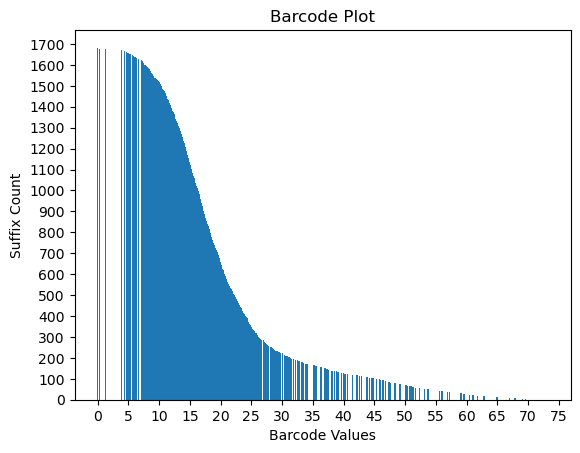

In [11]:
def graph():
    x, y = np.unique(deathes, return_counts=True)
    # fix np.inf
    x[-1] = x[-2]

    y = y[::-1].cumsum()[::-1]
    fig, ax = plt.subplots()
    ax.bar(x, y, width=0.1)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.set_xlabel('Barcode Values')
    ax.set_ylabel('Suffix Count')
    ax.set_title('Barcode Plot')
    plt.show()
graph()

- Il existe un virage et des espaces à partir de 200, et on a bien environ 200 catégories et il existe des espaces aussi à partir de cela; peut-être on peut trouver quelque chose.

Mais en fait, tout ce que fait en général le persistence module est de faire union à un component connexe. Il existe de bons résultats localement mais rien très util.

On en déduit que les données sont parse comme avant.

In [12]:
def connected_components_under_dist(X : csr_matrix, dist_lim : float):
  n = X.shape[0]
  G = csr_matrix(metrics.pairwise_distances(X, metric='euclidean', n_jobs=-1)<dist_lim)
  return csgraph.connected_components(G)

In [13]:
nc, labels = connected_components_under_dist(vecs, 6)
def incre(d : dict, key):
  d[key] = d.get(key, 0) + 1
statistics = [dict() for _ in range(nc)]
for i in range(len(labels)):
  for cate in pairs[i][0]:
    incre(statistics[labels[i]], cate)
  incre(statistics[labels[i]], 'cnt')
  statistics[labels[i]][i] = True
for i in range(nc):
  if statistics[i]['cnt'] == 1:
    continue
  print(i, statistics[i]['cnt'], end='')
  print(statistics[i])



10 31{'Parcours': 1, 'Médiéval-fantastique': 3, 'Déplacement': 3, 'Exploration': 2, 'Monstre': 1, 'Hasard (Dé, Cartes, ...)': 5, 'cnt': 31, 10: True, 'Casual': 4, 'Vote': 1, 'Lettres / mots': 2, 'Stop ou encore': 1, 13: True, 'Construction': 1, 'Connexions': 2, 'Placement': 3, 277: True, 'Choix simultanés': 1, 'Course': 1, 'Dés': 7, 'Diplomatie': 3, 'Pirate': 1, 'Programmation': 1, 408: True, 'Asie': 2, 'Jeux de pions': 1, 647: True, 'Amateur': 2, 'Jeu de carte à collectionner': 1, 712: True, 'Commerce': 3, 715: True, 'Geek': 4, 'Jeux de plateau': 4, 758: True, 'Jeux de cartes': 4, 876: True, 'Ambiance': 1, 'Bluff': 2, 'Déduction': 1, 'Elimination': 1, 'Loups-garous': 1, 'Guessing': 1, 'Pioche': 2, 'Rôle': 1, 'Rôle secret': 1, 'Trahison': 2, 919: True, 'Casse-tête': 2, 950: True, 952: True, 'Jeux de figurines': 1, 968: True, 969: True, 980: True, 'Combinaison': 8, 'Locomotion & voyage': 2, 1018: True, 'Jeux de connaissances': 1, 1047: True, 1086: True, 1145: True, 'Fantastique': 1, 'Le

In [14]:
print(pairs[644][1], '---')
print(pairs[650][1], '---')


                      Ce booster contient :

les personnages uniques Negan et Andy,
un rôdeur inédit,
quatre cartes d'équipements
deux cartes de personnages (Negan et Andy).

La boîte de base du jeu de figurines "The Walking Dead : All Out War" est nécessaire pour jouer.
                   ---

                      Ce booster contient :

les personnages uniques Lee & Clementine les deux personnages emblématiques du jeu de TellTale, 
un rôdeur inédit, 
quatre cartes d'équipements,
deux cartes de personnages

La boîte de base du jeu de figurines "The Walking Dead : All Out War" est nécessaire pour jouer.
                   ---
